# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os

In [2]:
# import sys
# sys.path.append(os.getcwd()+"/workplace/selfdevelopment/courses/project_cs231n/assignments_for_git/")

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

from export_modules import *
from utils.datasets.data_import import *
from utils.general_utils.notebook_utils import *

In [3]:
# Load the raw CIFAR-10 data.
project_path = os.getcwd() + "/../.."
cifar10_dir = project_path + '/data'
X_train, Y_train, X_test, Y_test = load_CIFAR10(cifar10_dir)

In [4]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', Y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', Y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [12]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

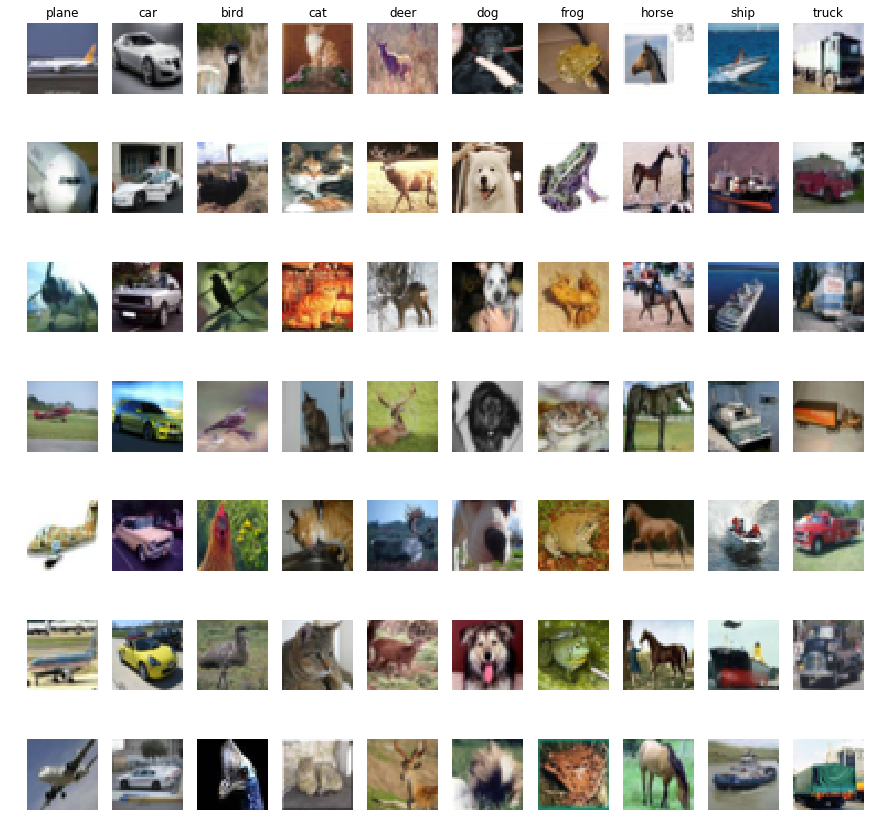

In [6]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
for y, cls in enumerate(classes):
    class_id = np.flatnonzero(Y_train == y)
    random_ids = np.random.choice(class_id, samples_per_class, replace=False)
    for i, random_id in enumerate(random_ids):
        plt.subplot(samples_per_class, num_classes,  i * num_classes + y + 1)
        plt.imshow(X_train[random_id].astype("uint8"))
        plt.axis('off')
        
        if i == 0:
            plt.title(cls)        
plt.show()

del num_classes, samples_per_class, y, cls, class_id, random_ids, random_id, i

In [7]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
num_test = 500

cut_data = get_CIFAR10_data(num_training=num_training, num_validation=0, 
                            num_test=num_test, subtract_mean=False)

X_train, Y_train = cut_data["X_train"], cut_data["Y_train"]
X_test, Y_test = cut_data["X_test"], cut_data["Y_test"]
del cut_data

<div class="alert alert-block alert-info">
<b><u>Remark:</b></u> 
    
We've saved each image as 3d numpy array.<br/>
So that we've got 4d numpy array of images.<br/><br/>

For computing all the distances between all the images 
we need one row of features per one object.<br/>
(Than we just use each row as a vector and make operations according to vector rules)<br/><br/>

<i class="fa fa-question-circle" style="font-size:22px;color:blue"></i>  How can we get it?<br/>
<i class="fa fa-exclamation-circle" style="font-size:22px;color:blue"></i> The simpliest way - just to write value-by-value of each numpy array to one row.<br/><br/>

The cell below convert each train object to such set of combinations.<br/>
</div>

In [8]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [9]:
print("Train dimension: %s\nTest dimension: %s" %(X_train.shape, X_test.shape))

Train dimension: (5000, 3072)
Test dimension: (500, 3072)


# K-nearest Neighbors

In [10]:
from utils.classifiers.k_nearest_neighbor import KNearestNeighbor

In [11]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)

<div class="alert alert-block alert-info">
We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

In `utils/classifiers/k_nearest_neighbor.py` implemented the function `compute_distances_2_loop` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.
<div/>

In [17]:
# Open utils/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_dist_2_loop(X_test)
print("Distance matrix shape: {}".format(dists.shape))

Distance matrix shape: (500, 5000)


In [18]:
print("Test first few values:\n")
print(dists[:2, :])

Test first few values:

[[3803.92350081 4210.59603857 5504.0544147  ... 4007.64756434
  4203.28086142 4354.20256764]
 [6336.83367306 5270.28006846 4040.63608854 ... 4829.15334194
  4694.09767687 7768.33347636]]


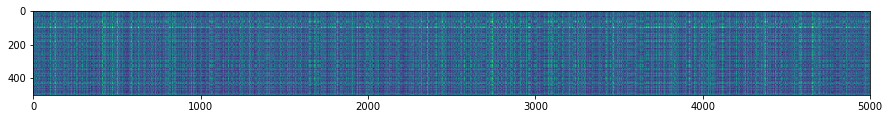

In [19]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

<div class="alert alert-success" role="alert">
<a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
  <i class="fa fa-question-circle" style="font-size:22px;color:green"></i> <strong><u> Question 1:</u></strong><br/>
    <hr>
    Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter.<br/>
    (Note that with the default color scheme black indicates low distances while white indicates high distances.)<br/><br/>
    - What in the data is the cause behind the distinctly bright rows?<br/>
    - What causes the columns?<br/>
    <hr>
</div>

$\color{green}{\underline{\textbf{Your answer:}}}$

* The bright lines are caused by the objects in test dataset, which are located extremely far from all the objects in train dataset

* The bright lines are caused by the objects in train dataset, which are located extremely far from all the objects in test dataset

In [20]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
Y_test_pred = classifier.predict_labels(dists, k=1)

In [21]:
# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(Y_test_pred == Y_test)
accuracy_value = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_value))
del accuracy_value, num_correct

Got 137 / 500 correct => accuracy: 0.274000


<div class="alert alert-block alert-info">
    
You should expect to see approximately <b>27%</b> accuracy.<br/> 
Now lets try out a larger $k$, say `k = 5`:

<div/>

In [22]:
Y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(Y_test_pred == Y_test)
accuracy_value = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_value))
del accuracy_value, num_correct

Got 139 / 500 correct => accuracy: 0.278000


<div class="alert alert-block alert-info">
    
You should expect to see a slightly better performance than with `k = 1`.

<div/>

<div class="alert alert-success" role="alert">
<a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
  <i class="fa fa-question-circle" style="font-size:22px;color:green"></i> <strong><u> Question 3:</u></strong> <br/>
    <hr>
    We can also use other distance metrics such as L1 distance.<br/>
    For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, the mean $\mu$ across all pixels over all images is 
    $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$<br/>
    And the pixel-wise mean $\mu_{ij}$ across all images is 
    $$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$<br/>
    The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.<br/><br/>
    Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.<br/>
    1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)<br/>
    2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)<br/>
    3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.<br/>
    4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.<br/>
    5. Rotating the coordinate axes of the data.<br/>
    <hr>
</div>

$\color{green}{\underline{\textbf{Your answer}}}$: 

1) 1, 2, 3

2) 5 - if the rotating angle 
$\theta \in \{ \pm \frac{\pi}{2} + 2 \pi k, k \in \mathbb{Z} \} \cup \{ \pm \frac{3\pi}{2} + 2 \pi k, k \in \mathbb{Z} \} \cup \{ 2 \pi k, k \in \mathbb{Z} \} \cup \{ \pm \pi + 2 \pi k, k \in \mathbb{Z} \}$</br>
and rotation is performed around the main axises.

$\color{green}{\underline{\textbf{Your Explanation}}}$

I. Subtracting the mean $\mu$: $\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.

**Intuitively**: &nbsp; &nbsp; The distance values are not affected by the shifting all the objects into the fixed constant.

**Analytically**: &nbsp; Let us denote $l_1$ distance between object $p^{(1)}$ and $p^{(2)}$ as

$$l_{1}(p^{(1)}, p^{(2)}) = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| p_{ij}^{(1)} - p_{ij}^{(2)} \right|$$

Lets subtract mean from each object $p^{(k)}, k=\overline{1, n}$. Than the distance between pictures $p^{(1)}$ and $p^{(2)}$ will be:

$$l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)}) = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| \tilde{p}_{ij}^{(1)} - \tilde{p}_{ij}^{(2)} \right| = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| p_{ij}^{(1)} - \mu - p_{ij}^{(2)} + \mu \right| = l_{1}(p^{(1)}, p^{(2)})$$

II. Subtracting the per pixel mean $\mu_{ij}$: $\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.

**Intuitively**: &nbsp; &nbsp; The distance values are not affected by the shifting each element of the objects into the fixed constant.

**Analytically**:
$$l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)}) = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| \tilde{p}_{ij}^{(1)} - \tilde{p}_{ij}^{(2)} \right| = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| p_{ij}^{(1)} - \mu_{ij} - p_{ij}^{(2)} + \mu_{ij} \right| = l_{1}(p^{(1)}, p^{(2)})$$

III.Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$: $\tilde{p}_{ij}^{(k)}=\frac{1}{\sigma} p_{ij}^{(k)}$.

**Intuitively**: &nbsp; &nbsp; All the distances will be divided by the same value. So that the KNN result will be not affected.

**Analytically**:
$$l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)}) = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| \tilde{p}_{ij}^{(1)} - \tilde{p}_{ij}^{(2)} \right| = \frac{1}{\sigma} \sum_{i=1}^{h} \sum_{j=1}^{w} \left| p_{ij}^{(1)} - p_{ij}^{(2)} \right| = \frac{1}{\sigma} l_{1}(p^{(1)}, p^{(2)})$$

IV. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$: $\tilde{p}_{ij}^{(k)}=\frac{p_{ij}^{(k)} - \mu_{ij}}{\sigma_{oj}}$.

**Intuitively**: &nbsp; &nbsp; All the distances will be divided by different values. <br/>
So that, in new scale the distances may be different from the original one.

**Analytically**:
$$l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)}) = \sum_{i=1}^{h} \sum_{j=1}^{w} \left| \tilde{p}_{ij}^{(1)} - \tilde{p}_{ij}^{(2)} \right| = \sum_{i=1}^{h} \sum_{j=1}^{w} \frac{\left| p_{ij}^{(1)} - \mu_{ij}- p_{ij}^{(2)} + \mu_{ij} \right|}{\sigma_{ij}} = \sum_{i=1}^{h} \sum_{j=1}^{w} \frac{\left| p_{ij}^{(1)} - p_{ij}^{(2)} \right|}{\sigma_{ij}}$$

VI. Rotating the coordinate axes of the data.

**Intuitively**: &nbsp; &nbsp; There will be no changes, if we rotate by $0$ or $2\pi$.<br/>
Also, it is obviously, that rotation by $\pm \frac{\pi}{2}$ has no influence on distance between rotated objects.<br/>
(All rotations are performed around main axises)

**Analytically**: Let us consider the simplest case, when eavery picture has $2 \times 1$ shape:

$$p^{(1)} = \begin{pmatrix} p_{11}^{(1)} \\ p_{21}^{(1)} \end{pmatrix}\text{, }
  p^{(2)} = \begin{pmatrix} p_{11}^{(2)} \\ p_{21}^{(2)} \end{pmatrix}.$$
  
[After rotation clockwise by $\theta$](https://en.wikipedia.org/wiki/Rotation_of_axes), we will get

$$\tilde{p}^{(1)} = \begin{pmatrix} p_{11}^{(1)} \cos{\theta} + p_{21}^{(1)} \sin{\theta} \\ - \sin{\theta} p_{11}^{(1)} +  p_{21}^{(1)} \cos{\theta} \end{pmatrix}\text{, }
  \tilde{p}^{(2)} = \begin{pmatrix} p_{11}^{(2)} \cos{\theta} + p_{21}^{(2)} \sin{\theta} \\ - \sin{\theta} p_{11}^{(2)} +  p_{21}^{(2)} \cos{\theta} \end{pmatrix}$$
  
If we compute $l_1$ distance, we will get:

$$l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)}) = \left| \tilde{p}_{11}^{(1)} - \tilde{p}_{11}^{(2)} \right| +
\left| \tilde{p}_{21}^{(1)} - \tilde{p}_{21}^{(2)} \right|=\\
\left| p_{11}^{(1)}\cos{\theta} + p_{21}^{(1)}\sin{\theta}- p_{11}^{(2)}\cos{\theta} - p_{21}^{(2)}\sin{\theta} \right| + \left| - p_{11}^{(1)}\sin{\theta} + p_{21}^{(1)}\cos{\theta} + p_{11}^{(2)}\sin{\theta} - p_{21}^{(2)}\cos{\theta} \right| = \\
\left| \cos{\theta} \left(p_{11}^{(1)} - p_{11}^{(2)}\right) +\sin{\theta} \left(p_{21}^{(1)} - p_{21}^{(2)} \right) \right| + \left| - \sin{\theta} \left( p_{11}^{(1)} - p_{11}^{(2)}\right) + \cos{\theta} \left(p_{21}^{(1)} - p_{21}^{(2)} \right) \right|
$$

The last expression equals $l_{1}(\tilde{p}^{(1)}, \tilde{p}^{(2)})$ if and only if:

$$\theta \in \{ \pm \frac{\pi}{2} + 2 \pi k, k \in \mathbb{Z} \} \cup \{ \pm \frac{3\pi}{2} + 2 \pi k, k \in \mathbb{Z} \} \cup \{ 2 \pi k, k \in \mathbb{Z} \} \cup \{ \pm \pi + 2 \pi k, k \in \mathbb{Z} \}$$

in more general case, if we have more axis and rotate around some main axis, we will have almost the same matrix (with appropriate dimensions).<br/>
The only remark: rotation matrix, according to our assumptions, consists of ones, zeros and $\sin, \ \cos$.<br/>
Ones response to the stable axis(es), $\sin, \cos$ - rotation. <br/>
So, we will have almost the same situation and the same answer.


In [23]:
from utils.general_utils.notebook_utils import *

In [24]:
# We use k = 1 (which is Nearest Neighbor).
Y_test_pred = classifier.predict_labels(dists, k=1)

num_test = Y_test.shape[0]
num_correct = np.sum(Y_test_pred == Y_test)

# Compute and print the fraction of correctly predicted examples
accuracy_value = accuracy(Y_test_pred, Y_test)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_value))
del accuracy_value, num_correct

Got 137 / 500 correct => accuracy: 0.274000


<div class="alert alert-block alert-info">
    
You should expect to see approximately <b>27%</b> accuracy. Now lets try out a larger $k$, say `k = 5`:
    
<div/>

In [25]:
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == Y_test)
accuracy_value = accuracy(y_test_pred, Y_test)
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_value))
del accuracy_value, Y_test_pred, y_test_pred

Got 139 / 500 correct => accuracy: 0.278000


<div class="alert alert-block alert-info">
    
You should expect to see a slightly better performance than with `k = 1`.

<div/>

In [26]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_dist_1_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [27]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_dist_0_loop(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [28]:
# Let's compare how fast the implementations are
two_loop_time = time_performance(classifier.compute_dist_2_loop, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_performance(classifier.compute_dist_1_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_performance(classifier.compute_dist_0_loop, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 41.899637 seconds
One loop version took 38.704823 seconds
No loop version took 0.293210 seconds


## Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [29]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
Y_train_folds = []

In [30]:
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #

X_train_folds = np.array_split(X_train, num_folds)
Y_train_folds = np.array_split(Y_train, num_folds)

In [31]:
# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

In [32]:
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #

for k in k_choices:
    
    print("*"*(61))
    print(" "*22 + "k = %s" %k)
    
    k_to_accuracies_list = []
    
    for i in range(num_folds):
        
        x_train_3d = np.delete(np.array(X_train_folds), i, 0)
        x_train = x_train_3d.reshape(x_train_3d.shape[0] * x_train_3d.shape[1], 
                                     x_train_3d.shape[2])

        y_train_3d = np.delete(np.array(Y_train_folds), i, 0)
        y_train = y_train_3d.reshape(y_train_3d.shape[0] * y_train_3d.shape[1], )

        classifier = KNearestNeighbor()
        classifier.train(x_train, y_train)
        
        y_pred = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        accuracy_i = accuracy(y_pred, Y_train_folds[i])
        k_to_accuracies_list.append(accuracy_i)
        
        print(("-"*20 + " Fold: {} / {} : {} " + "-"*20).format(i+1, num_folds, accuracy_i))
    
    k_to_accuracies[k] = k_to_accuracies_list

*************************************************************
                      k = 1
-------------------- Fold: 1 / 5 : 0.263 --------------------
-------------------- Fold: 2 / 5 : 0.257 --------------------
-------------------- Fold: 3 / 5 : 0.264 --------------------
-------------------- Fold: 4 / 5 : 0.278 --------------------
-------------------- Fold: 5 / 5 : 0.266 --------------------
*************************************************************
                      k = 3
-------------------- Fold: 1 / 5 : 0.239 --------------------
-------------------- Fold: 2 / 5 : 0.249 --------------------
-------------------- Fold: 3 / 5 : 0.24 --------------------
-------------------- Fold: 4 / 5 : 0.266 --------------------
-------------------- Fold: 5 / 5 : 0.254 --------------------
*************************************************************
                      k = 5
-------------------- Fold: 1 / 5 : 0.248 --------------------
-------------------- Fold: 2 / 5 : 0.266 --------

In [33]:
mean_accuracy = {k:np.mean(v) for k, v in k_to_accuracies.items()}
std_accracy = {k:np.std(v) for k, v in k_to_accuracies.items()}

In [34]:
colors = ["blue"]*4
colors.append("red")
colors = colors + ["blue"]*5

In [35]:
x1, y1 = max(mean_accuracy.items(), key=itemgetter(1))
data = go.Scatter(x=list(k_to_accuracies.keys()), 
                  y=list(mean_accuracy.values()),
                  error_y=dict(type='data', array=list(std_accracy.values()), 
                               visible=True, color='#85144B'), 
                  marker=dict(color=colors), showlegend=False)
data1 = go.Scatter(x=[x1]*2, y=np.arange(0.21, 0.32, 0.1), 
                   line = dict(color = "grey",
                               width = 1.75, dash = 'dash'), 
                  marker=dict(color="grey", size=1), showlegend=False)
layout = go.Layout(height=600, width=1000,
                   yaxis=dict(title="Cross-validation accuracy",
                              range=[0.23, 0.298]),
                   xaxis=dict(title="k",
                              tickfont=dict(size=11, color='black'), tickangle=0,
                              showticklabels=True, tickvals = list(k_to_accuracies.keys())),
                   title="<b>Cross-validation on k</b>",
                   titlefont=dict(size=35))
fig = go.Figure([data, data1], layout=layout)
iplot(fig, filename='basic-error-bar')

In [36]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)
Y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(Y_test_pred == Y_test)
accuracy_value = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy_value))

Got 141 / 500 correct => accuracy: 0.282000


<div class="alert alert-success" role="alert">
<a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
  <i class="fa fa-question-circle" style="font-size:22px;color:green"></i> <strong><u> Question 3:</u></strong> <br/>
    <hr>
    Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.<br/>
    1. The decision boundary of the k-NN classifier is linear.<br/>
    2. The training error of a 1-NN will always be lower than that of 5-NN.<br/>
    3. The test error of a 1-NN will always be lower than that of a 5-NN.<br/>
    4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.<br/>
    5. None of the above.<br/>
    <hr>
</div>

${\color{green}{\underline{\textbf{Your Answer:}}}}$ 2, 4 <br/>


${\color{green}{\underline{\textbf{Your Explanation:}}}}$<br/>
<b>I. The decision boundary of the k-NN classifier is linear.</b>

The main idea of the k-NN classifier is not to draw dividing lines between classes, but make piecewise linear splitting. Thus, the decision boundary of the k-NN classifier is similar to polygon. 

<b>II. The training error of a 1-NN will always be lower than that of 5-NN.</b>

The training error of a 1-NN will always be 0. Distance between self and self is always 0. Since we choose 1 neighbor to classify (self label), the classification result will always be true.


<b>III. The test error of a 1-NN will always be lower than that of a 5-NN.</b>

It depends on training and test data.

<b>IV. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.</b>

Because of computation distance to each object from train data.

# Plot the nearest objects


In [4]:
from utils.classifiers.k_nearest_neighbor import KNearestNeighbor
from utils.general_utils.notebook_utils import *

In [5]:
X_train_, Y_train_, X_test_, Y_test_ = load_CIFAR10(cifar10_dir)
num_training = 50000
num_test = 1000

cut_data = get_CIFAR10_data(num_training=num_training, num_validation=0, 
                            num_test=num_test, subtract_mean=False)

X_train, Y_train = cut_data["X_train"], cut_data["Y_train"]
X_test, Y_test = cut_data["X_test"], cut_data["Y_test"]
del cut_data

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

In [6]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, Y_train)

dist = classifier.compute_dist_0_loop(X_test)
label_indexes = np.argsort(dist, axis=1)[:, :best_k]

# Choose random image from test set
random_image_ind = np.random.choice(range(Y_test.shape[0]), size=5, 
                                    replace=False)
random_5_label_indexes = label_indexes[random_image_ind, ]

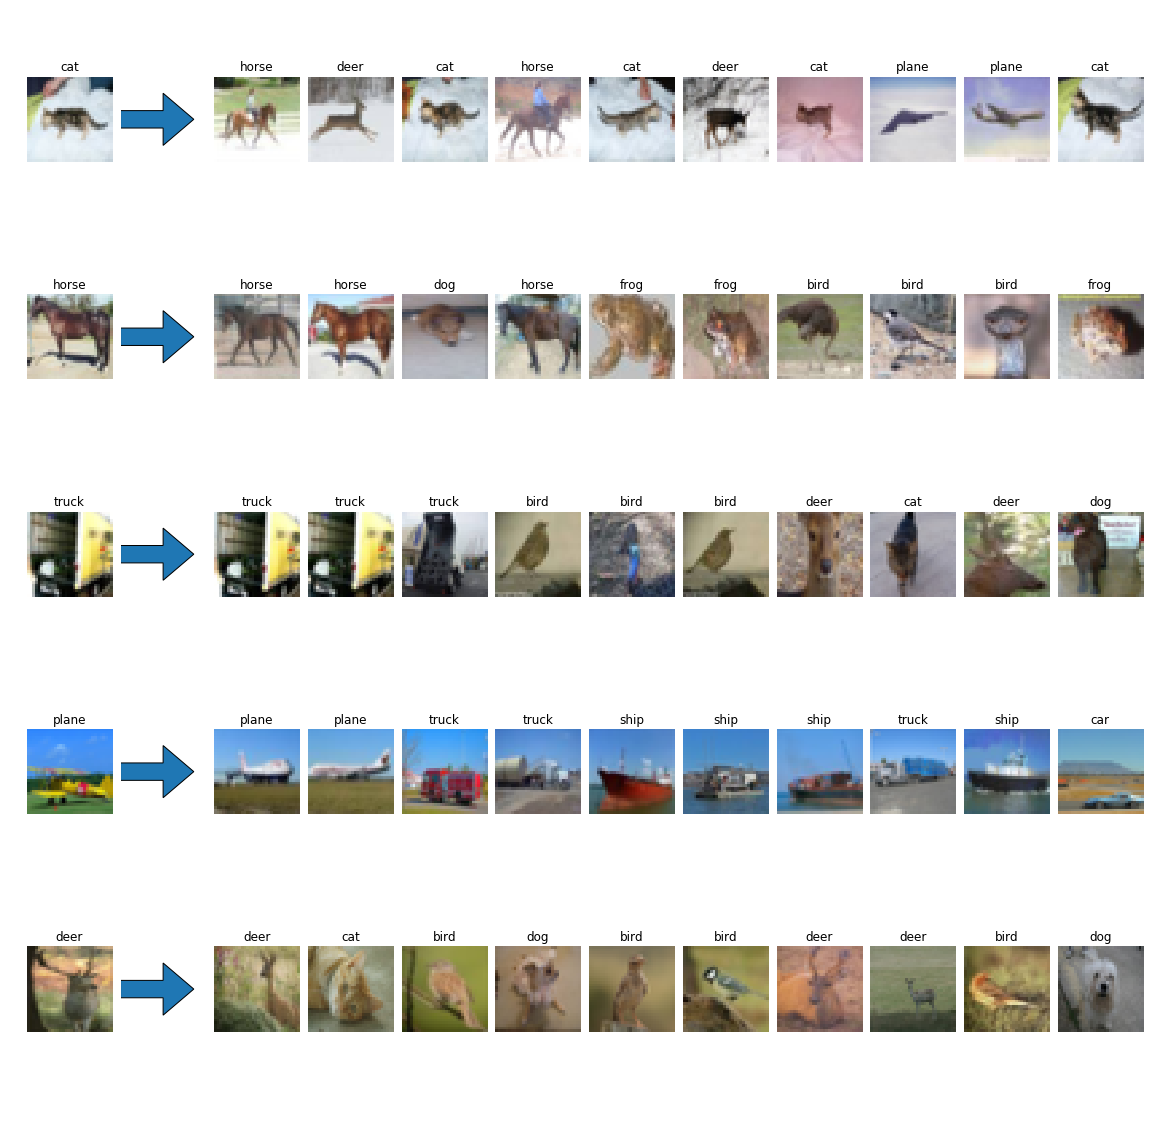

In [7]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0.1, hspace=0)
for j in range(0, 5):
    if j == 0:
        ind1 = 1 
        ind2 = 2
    else:
        ind1 = j*12+1
        ind2 = j*12+2
        
    plt.subplot(5, 12, ind1)
    plt.imshow(X_test_[random_image_ind[j]].astype("uint8"))
    plt.axis('off')
    plt.title(classes[Y_test[random_image_ind[j],].astype("int")])
    
    plt.subplot(5, 12, ind2)
    plt.arrow(0, 0.5, 0.5, 0., width=0.08)
    plt.axis('off')
    
    for i in range(0, best_k):
        ind = ind2 + i + 1
        plt.subplot(5, 12, ind)
        plt.imshow(X_train_[random_5_label_indexes[j, i]].astype("uint8"))
        plt.title(classes[Y_train_[random_5_label_indexes[j, i]].astype("int")])
        plt.axis('off')
plt.show()

In [8]:
dist = classifier.compute_dist_l1(X_test)
label_indexes = np.argsort(dist, axis=1)[:, :best_k]

In [10]:
random_5_label_indexes = label_indexes[random_image_ind, ]

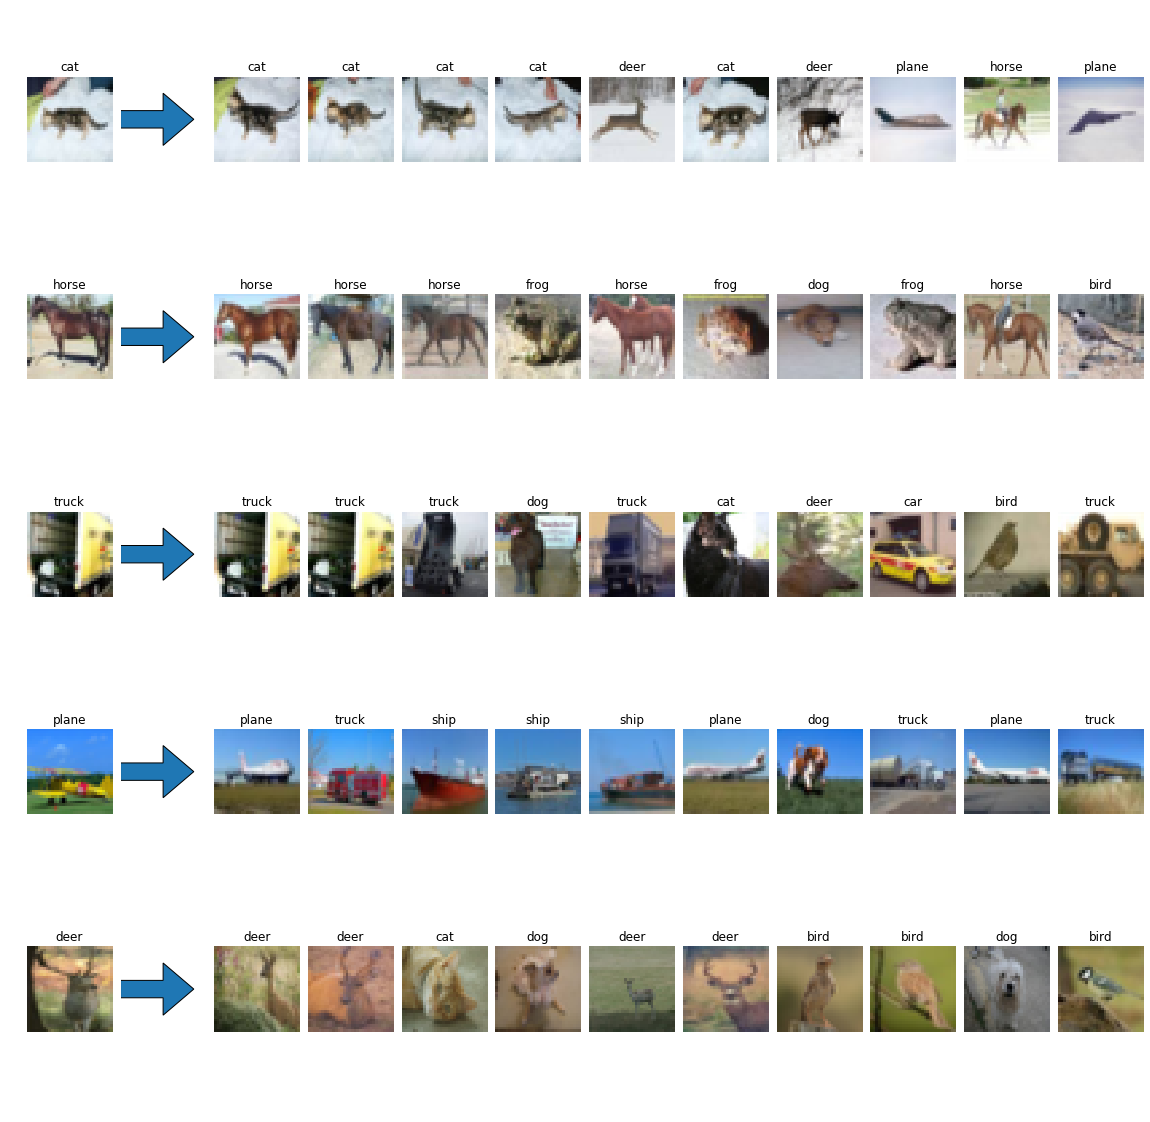

In [11]:
plt.rcParams['figure.figsize'] = (20.0, 20.0)
plt.subplots_adjust(wspace=0.1, hspace=0)
for j in range(0, 5):
    if j == 0:
        ind1 = 1 
        ind2 = 2
    else:
        ind1 = j*12+1
        ind2 = j*12+2
        
    plt.subplot(5, 12, ind1)
    plt.imshow(X_test_[random_image_ind[j]].astype("uint8"))
    plt.axis('off')
    plt.title(classes[Y_test[random_image_ind[j],].astype("int")])
    
    plt.subplot(5, 12, ind2)
    plt.arrow(0, 0.5, 0.5, 0., width=0.08)
    plt.axis('off')
    
    for i in range(0, best_k):
        ind = ind2 + i + 1
        plt.subplot(5, 12, ind)
        plt.imshow(X_train_[random_5_label_indexes[j, i]].astype("uint8"))
        plt.title(classes[Y_train_[random_5_label_indexes[j, i]].astype("int")])
        plt.axis('off')
plt.show()

<div class="alert alert-block alert-info">
<b> Small Conclusion:</b>
<hr>

It seams, that too large penalty of small differences is inappropriate for defining pictures similarity. Especially, when the background place too much space. <br/>
Let us highlight, that k-NN is to much sensitive to background.
    
<div/>